In [1]:
# Currently modifying model layers
# Validation Accuracy Goal: 70%

In [2]:
# Loading training images, testing images, and image labels from CIFAR-10 folder

import os

training_path = 'CIFAR-10 Images/Training/'
testing_path = 'CIFAR-10 Images/Testing'
label_path = 'CIFAR-10 Images/batches.meta'

training_data = []
training_label_data = []
testing_data = []
testing_label_data = []

def unpickle_file(file):
    import pickle
    with open(file, 'rb') as tmp:
        dict = pickle.load(tmp, encoding='bytes')
    return dict

label_names = unpickle_file(label_path)[b'label_names']

def process_files(folder_path, data_container, label_container):
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            dict = unpickle_file(file_path)
            data, labels = dict[b'data'], dict[b'labels']
            data_container.append(data)
            label_container.append(labels)

process_files(training_path, training_data, training_label_data)
process_files(testing_path, testing_data, testing_label_data)

In [3]:
# Reshaping the image data from (3072,) to (32, 32, 3)

import numpy as np

def reshape_image(image_1d_array):
    # Setting up an empty 3D array of zeros to put in data
    image_reshaped = np.zeros((32, 32, 3), dtype=np.uint8)

    # Red
    image_reshaped[:, :, 0] = image_1d_array[:1024].reshape(32, 32)
    # Green
    image_reshaped[:, :, 1] = image_1d_array[1024:2048].reshape(32, 32)
    # Blue
    image_reshaped[:, :, 2] = image_1d_array[2048:].reshape(32, 32)

    return image_reshaped

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers

def create_cnn_model():    
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.25),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss = tf.keras.losses.get('sparse_categorical_crossentropy'),
                 metrics=['accuracy'])

    model.summary()

    return model

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

all_images = []
all_labels = []

for batch in training_data:
    for img in batch:
        reshaped_image = reshape_image(img)
        all_images.append(reshaped_image)

for batch in training_label_data:
    for label in batch:
        all_labels.append(label)

x_train = np.array(all_images)
y_train = np.array(all_labels)

x_val = np.array([reshape_image(img) for img in testing_data[0]])
y_val = np.array(testing_label_data[0])

datagen = ImageDataGenerator(
    rotation_range=20,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    shear_range=0.2,            
    zoom_range=0.2,             
    horizontal_flip=True,       
    fill_mode='nearest'         
)

datagen.fit(x_train)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = create_cnn_model()

batch_size = 64

history = model.fit(x_train, 
                    y_train, 
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val), 
                    callbacks=[lr_scheduler, early_stopping],
                    verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,890 (433.16 KB)

 Trainable params: 110,442 (431.41 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.2554 - loss: 2.1527 - val_accuracy: 0.4030 - val_loss: 1.7064 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4473 - loss: 1.5722 - val_accuracy: 0.4302 - val_loss: 1.5951 - learning_rate: 9.0000e-04
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5184 - loss: 1.3967 - val_accuracy: 0.5220 - val_loss: 1.3540 - learning_rate: 8.1000e-04
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5698 - loss: 1.2507 - val_accuracy: 0.6409 - val_loss: 1.0490 - learning_rate: 7.2900e-04
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6067 - loss: 1.1501 - val_accuracy: 0.6437 - val_loss: 1.0701 - learning_rate: 6.5610e-04
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6312 - loss: 1.0877 - val_accuracy: 0.6764 - val_loss: 0.9709 - learning_rate: 5.9049e-04
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accura

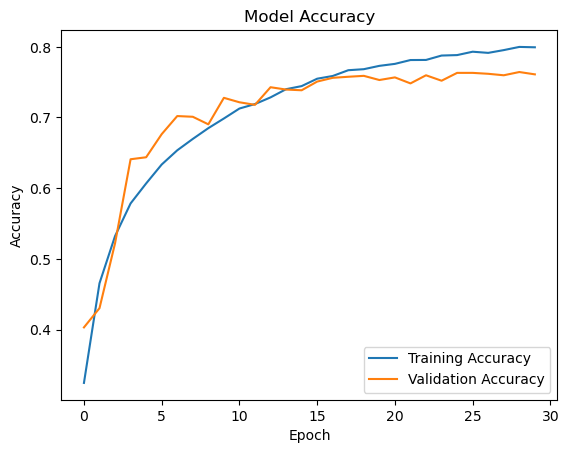

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

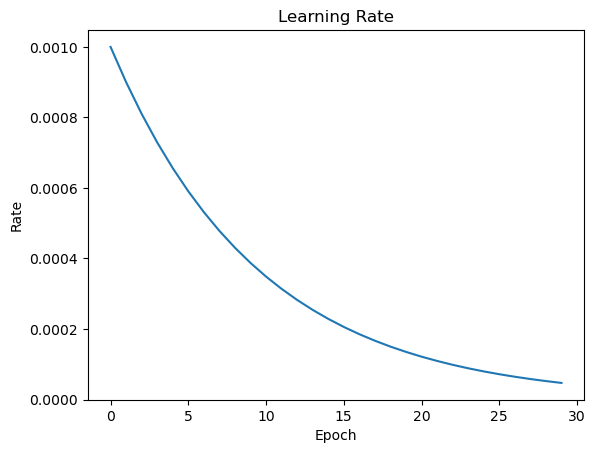

In [7]:
plt.plot(history.history['learning_rate'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.show()

In [8]:
loss, acc = model.evaluate(x_val, y_val, verbose=2)

313/313 - 1s - 2ms/step - accuracy: 0.7643 - loss: 0.7589


In [9]:
model.save('image_classification_model.keras')